In [25]:
### Creating Combat Log Table

In [26]:
# what needs to happen is that a table needs to be created that stores each turn in combat and the actions that happened in that turn.
# the table should have the following columns:

# create the table in the form of a dataframe
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt


# create the table
combat_log = pd.DataFrame(columns=[
                                   'Combat Round',
                                   'Action Number',
                                   'Action Time', # action, bonus action, reaction, etc
                                   'Action Name', # attack, cast spell, dodge, etc
                                   'Action Type', # attack, support, heal, control, etc
                                   'Target',
                                   'Action Result',
                                   'Current Allied Ability Check',
                                   'Current Allied Attack Roll',
                                   'Current Allied Saving Throw',
                                   'Current Allied Damage Roll',
                                   'Current Enemy Ability Check',
                                   'Current Enemy Attack Roll',
                                   'Current Enemy Saving Throw',
                                   'Current Enemy Damage Roll',
                                   ])

In [27]:
import Species
import Backgrounds
import Armor_and_Weapons
import Dice_Rolls
import Establishing_Hierarchy
import CHARACTER_CREATOR
import Monsters

import Character_Actions

In [28]:
def generate_situation(character_num):
    print('generating situation...')

    # for the number of characters, randomly generate a Player_Character using Random_Character()
    entities = []
    print('generating characters...')
    for i in range(character_num):
        entities.append(CHARACTER_CREATOR.Random_Character())

    # for the number of entities, within each entity's flesh out the Active_Conditions and Circumstances dictionaries
    for entity in range(len(entities)):
        other_entities = entities.copy()
        other_entities.pop(entity)
        
        # I want to add a key for each other entity in the Active_Conditions dictionaries
        for other_entity in range(len(other_entities)):
            entities[entity].Active_Conditions[str(entities[other_entity].Name)] = []
        
    return entities



def generate_combat(character_num):
    print('generating combat...')

    combat_log_new = pd.DataFrame(columns=[
                                   'Combat Round',
                                   'Action Number',
                                   'Action Time', # action, bonus action, reaction, etc
                                   'Action Name', # attack, cast spell, dodge, etc
                                   'Action Type', # attack, support, heal, control, etc
                                   'Target',
                                   'Action Result',
                                   'Current Allied Ability Check',
                                   'Current Allied Attack Roll',
                                   'Current Allied Saving Throw',
                                   'Current Allied Damage Roll',
                                   'Current Enemy Ability Check',
                                   'Current Enemy Attack Roll',
                                   'Current Enemy Saving Throw',
                                   'Current Enemy Damage Roll',
                                   ])
    # create situation
    combat_situation = generate_situation(character_num)
    

    print('adding action options...')
    for entity in range(len(combat_situation)):
        combat_situation[entity].Actions['None'] = Character_Actions.No_Action(combat_situation[entity],combat_situation,combat_log_new)
        combat_situation[entity].Bonus_Actions['None'] = Character_Actions.No_Bonus_Action(combat_situation[entity],combat_situation,combat_log_new)
        combat_situation[entity].Actions['Attack'] = Character_Actions.Attack_Action(combat_situation[entity],combat_situation,combat_log_new)
        combat_situation[entity].Actions['Dodge'] = Character_Actions.Dodge_Action(combat_situation[entity],combat_situation,combat_log_new)
        combat_situation[entity].Free_Actions['Move'] = Character_Actions.Move(combat_situation[entity],combat_situation,combat_log_new)
        Character_Actions.Equip_Weapon(combat_situation[entity],Character_Actions.Choose_Random_Weapon(combat_situation[entity]))

        # assign a unique location to each entity within a 12x12 grid
        combat_situation[entity].Location['X'] = np.random.randint(0,12)
        combat_situation[entity].Location['Y'] = np.random.randint(0,12)
        combat_situation[entity].Location['Z'] = 0
        
    combat_round = 0
    combat_log_new['Combat Round'] = combat_round
    

    def take_turn(combat_log_new,character):
        # need to decide which action_type to take first: Actions or Bonus_Actions
        action_types = ['Actions','Bonus_Actions','Movement']
        first_action_type = np.random.choice(action_types)
        # choose a second action type from the list minus the first action type
        second_action_type = np.random.choice([action for action in action_types if action != first_action_type])
        third_action_type = np.random.choice([action for action in action_types if action != first_action_type and action != second_action_type])

        if first_action_type == 'Actions':
            first_action = np.random.choice(['None','Attack','Dodge'])
            new_turn = combat_situation[character].Actions[first_action]
        elif first_action_type == 'Bonus_Actions':
            first_action = np.random.choice(['None'])
            new_turn = combat_situation[character].Bonus_Actions[first_action]
        elif first_action_type == 'Movement':
            new_turn = combat_situation[character].Free_Actions['Move']
                
        if second_action_type == 'Actions':
            second_action = np.random.choice(['None','Attack','Dodge'])
            new_turn = pd.concat([new_turn, combat_situation[character].Actions[second_action]], ignore_index=True, axis=0)
        elif second_action_type == 'Bonus_Actions':
            second_action = np.random.choice(['None'])
            new_turn = pd.concat([new_turn, combat_situation[character].Bonus_Actions[second_action]], ignore_index=True, axis=0)
        elif second_action_type == 'Movement':
            new_turn = pd.concat([new_turn, combat_situation[character].Free_Actions['Move']], ignore_index=True, axis=0)        
        
        if third_action_type == 'Actions':
            third_action = np.random.choice(['None','Attack','Dodge'])
            new_turn = pd.concat([new_turn, combat_situation[character].Actions[third_action]], ignore_index=True, axis=0)
        elif third_action_type == 'Bonus_Actions':
            third_action = np.random.choice(['None'])
            new_turn = pd.concat([new_turn, combat_situation[character].Bonus_Actions[third_action]], ignore_index=True, axis=0)
        elif third_action_type == 'Movement':
            new_turn = pd.concat([new_turn, combat_situation[character].Free_Actions['Move']], ignore_index=True, axis=0)            



        #new_round = combat_situation[character].first_action_type[first_action]
        #new_round = pd.concat([new_round, combat_situation[character].second_action_type[second_action]], ignore_index=True, axis=0)


        #action = np.random.choice(['None','Attack','Dodge'])
        #bonus_action = np.random.choice(['None'])
        #new_round = combat_situation[character].Actions[action]
        #combat_log_new = pd.concat([combat_log_new, new_round], ignore_index=True, axis=0)
        return new_turn

    print('taking turns...')
    for entity in range(len(combat_situation)):
        combat_log_new = pd.concat([combat_log_new,take_turn(combat_log_new,entity)], ignore_index=True, axis=0)


    combat_log_new = combat_log_new.reindex(columns=['Combat Round'] + list(combat_log_new.columns[1:][combat_log_new.columns[1:].str.contains('Acting True')]) + list(combat_log_new.columns[1:][combat_log_new.columns[1:].str.contains('Current_HP')]) + list(combat_log_new.columns[1:][~combat_log_new.columns[1:].str.contains('Acting True') & ~combat_log_new.columns[1:].str.contains('Current_HP')]))

    # print the locations of each creature using a plot
    print('plotting locations...')
    plt.figure(figsize=(12,12))
    for entity in range(len(combat_situation)):
        plt.scatter(combat_situation[entity].Location['X'],combat_situation[entity].Location['Y'],label=combat_situation[entity].Name)
    plt.legend()
    plt.grid(True)
    plt.xlim(0,12)
    plt.ylim(0,12)
    plt.show()
    

    return combat_log_new


In [29]:
# remove the number of columns limit
pd.set_option('display.max_columns', None)

generating combat...
generating situation...
generating characters...
Character_Creator - Random Character Function - Class Choice:  <module 'Bard' from 'c:\\Users\\maxhi\\OneDrive\\Documents\\GitHub\\5e-Simulation\\Bard.py'>
Create Character Function - Class: <module 'Bard' from 'c:\\Users\\maxhi\\OneDrive\\Documents\\GitHub\\5e-Simulation\\Bard.py'>
Character_Creator - Random Character Function - Class Choice:  <module 'Artificer' from 'c:\\Users\\maxhi\\OneDrive\\Documents\\GitHub\\5e-Simulation\\Artificer.py'>
Create Character Function - Class: <module 'Artificer' from 'c:\\Users\\maxhi\\OneDrive\\Documents\\GitHub\\5e-Simulation\\Artificer.py'>
Character_Creator - Random Character Function - Class Choice:  <module 'Bard' from 'c:\\Users\\maxhi\\OneDrive\\Documents\\GitHub\\5e-Simulation\\Bard.py'>
Create Character Function - Class: <module 'Bard' from 'c:\\Users\\maxhi\\OneDrive\\Documents\\GitHub\\5e-Simulation\\Bard.py'>
Character_Creator - Random Character Function - Class Choi

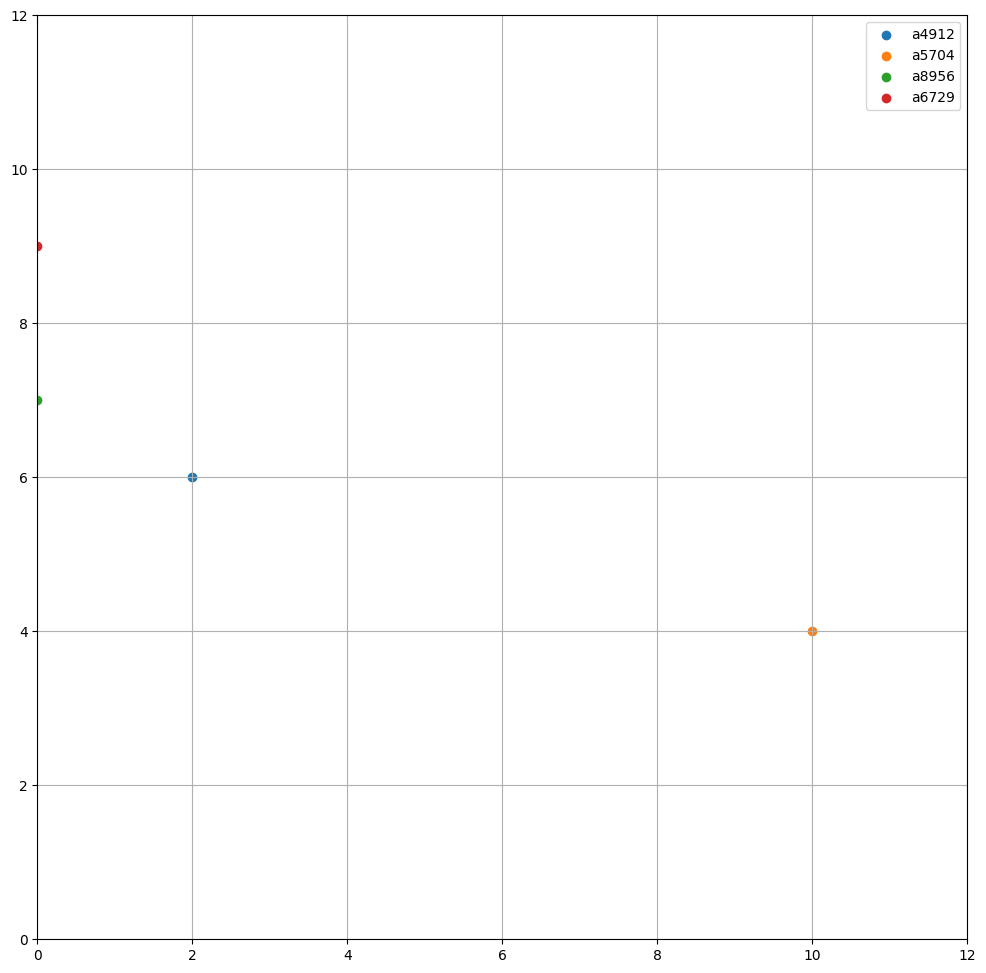

,Combat Round,a4912 Acting True,a5704 Acting True,a8956 Acting True,a6729 Acting True,a4912 Current_HP,a5704 Current_HP,a8956 Current_HP,a6729 Current_HP,Action Number,Action Time,Action Name,Action Type,Target,Action Result,Current Allied Ability Check,Current Allied Attack Roll,Current Allied Saving Throw,Current Allied Damage Roll,Current Enemy Ability Check,Current Enemy Attack Roll,Current Enemy Saving Throw,Current Enemy Damage Roll,a4912 Temp_HP,a4912 Size,a4912 Walking Speed,a4912 Flying Speed,a4912 Str_Score,a4912 Dex_Score,a4912 Con_Score,a4912 Int_Score,a4912 Wis_Score,a4912 Cha_Score,a4912 Active_Conditions,a4912 Concentrating,a4912Location X,a4912Location Y,a4912Location Z,a5704 Temp_HP,a5704 Size,a5704 Walking Speed,a5704 Flying Speed,a5704 Str_Score,a5704 Dex_Score,a5704 Con_Score,a5704 Int_Score,a5704 Wis_Score,a5704 Cha_Score,a5704 Active_Conditions,a5704 Concentrating,a5704Location X,a5704Location Y,a5704Location Z,a8956 Temp_HP,a8956 Size,a8956 Walking Speed,a8956 Flying Speed,a8956 Str_Score,a8956 Dex_Score,a8956 Con_Score,a8956 Int_Score,a8956 Wis_Score,a8956 Cha_Score,a8956 Active_Conditions,a8956 Concentrating,a8956Location X,a8956Location Y,a8956Location Z,a6729 Temp_HP,a6729 Size,a6729 Walking Speed,a6729 Flying Speed,a6729 Str_Score,a6729 Dex_Score,a6729 Con_Score,a6729 Int_Score,a6729 Wis_Score,a6729 Cha_Score,a6729 Active_Conditions,a6729 Concentrating,a6729Location X,a6729Location Y,a6729Location Z
0,0,1.0,0.0,0.0,0.0,10.0,10.0,9.0,12.0,Undetermined,Bonus Action,None,Passive,a4912,None,<Dice_Rolls.Ability_Check object at 0x00000283...,<Dice_Rolls.Attack_Roll object at 0x000002839C...,<Dice_Rolls.Saving_Throw object at 0x000002839...,<Dice_Rolls.Damage_Roll object at 0x000002839C...,<Dice_Rolls.Ability_Check object at 0x00000283...,<Dice_Rolls.Attack_Roll object at 0x000002839C...,<Dice_Rolls.Saving_Throw object at 0x000002839...,<Dice_Rolls.Damage_Roll object at 0x000002839C...,0.0,Medium,30.0,0.0,15.0,8.0,12.0,14.0,13.0,12.0,NaN,False,0.0,0.0,0.0,0.0,Medium,30.0,0.0,12.0,8.0,10.0,14.0,15.0,13.0,NaN,False,0.0,0.0,0.0,0.0,Medium,30.0,0.0,12.0,15.0,8.0,13.0,14.0,10.0,NaN,False,0.0,0.0,0.0,0.0,Medium,30.0,0.0,13.0,15.0,16.0,10.0,12.0,8.0,NaN,False,0.0,0.0,0.0
1,0,1.0,0.0,0.0,0.0,10.0,10.0,9.0,12.0,Undetermined,Action,None,Passive,a4912,None,<Dice_Rolls.Ability_Check object at 0x00000283...,<Dice_Rolls.Attack_Roll object at 0x000002839C...,<Dice_Rolls.Saving_Throw object at 0x000002839...,<Dice_Rolls.Damage_Roll object at 0x000002839C...,<Dice_Rolls.Ability_Check object at 0x00000283...,<Dice_Rolls.Attack_Roll object at 0x000002839C...,<Dice_Rolls.Saving_Throw object at 0x000002839...,<Dice_Rolls.Damage_Roll object at 0x000002839C...,0.0,Medium,30.0,0.0,15.0,8.0,12.0,14.0,13.0,12.0,NaN,False,0.0,0.0,0.0,0.0,Medium,30.0,0.0,12.0,8.0,10.0,14.0,15.0,13.0,NaN,False,0.0,0.0,0.0,0.0,Medium,30.0,0.0,12.0,15.0,8.0,13.0,14.0,10.0,NaN,False,0.0,0.0,0.0,0.0,Medium,30.0,0.0,13.0,15.0,16.0,10.0,12.0,8.0,NaN,False,0.0,0.0,0.0
2,0,1.0,0.0,0.0,0.0,10.0,10.0,5.0,12.0,Undetermined,Action,Move,Movement,a4912,Moved,<Dice_Rolls.Ability_Check object at 0x00000283...,<Dice_Rolls.Attack_Roll object at 0x000002839C...,<Dice_Rolls.Saving_Throw object at 0x000002839...,<Dice_Rolls.Damage_Roll object at 0x000002839C...,<Dice_Rolls.Ability_Check object at 0x00000283...,<Dice_Rolls.Attack_Roll object at 0x000002839C...,<Dice_Rolls.Saving_Throw object at 0x000002839...,<Dice_Rolls.Damage_Roll object at 0x000002839C...,0.0,Medium,30.0,0.0,15.0,8.0,12.0,14.0,13.0,12.0,NaN,False,1.0,24.0,0.0,0.0,Medium,30.0,0.0,12.0,8.0,10.0,14.0,15.0,13.0,NaN,False,0.0,0.0,0.0,0.0,Medium,30.0,0.0,12.0,15.0,8.0,13.0,14.0,10.0,NaN,False,0.0,0.0,0.0,0.0,Medium,30.0,0.0,13.0,15.0,16.0,10.0,12.0,8.0,NaN,False,0.0,0.0,0.0
3,0,0.0,1.0,0.0,0.0,10.0,7.0,5.0,12.0,Undetermined,Action,Dodge,Defense,a5704,Dodge,<Dice_Rolls.Ability_Check object at 0x00000283...,<Dice_Rolls.Attack_Roll object at 0x000002839C...,<Dice_Rolls.Saving_Throw object at 0x000002839...,<Dice

In [30]:
generate_combat(4)